In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

# Cargar los datos desde el archivo Excel
df = pd.read_excel("Exportaciones.xlsx", sheet_name="2. Total_Valor", usecols="C:D", skiprows=6)  # Ajuste para saltar las primeras 6 filas

# Extraer la serie de tiempo
serie_val = df.iloc[:, 1].values.reshape(-1, 1)  # Asegurarse de que sea una matriz 2D

# Transformación: Logaritmo natural y primera diferencia
log_serie = np.log(serie_val)  # Aplicar logaritmo natural
diff_log_serie = np.diff(log_serie, axis=0)  # Aplicar primera diferencia

# Convertir la serie transformada en un DataFrame
transformed_df = pd.DataFrame(diff_log_serie, columns=["Diff_Log_Valor"])

# Normalizar los datos
scaler = MinMaxScaler()
serie_val_scaled = scaler.fit_transform(transformed_df)

# Función para crear ventanas deslizantes
def create_sequences(data, window_size):
    sequences = []
    targets = []
    for i in range(len(data) - window_size):
        sequences.append(data[i:i + window_size])
        targets.append(data[i + window_size])
    return np.array(sequences), np.array(targets)

# Definir el tamaño de la ventana
window_size = 24

# Crear las secuencias y los objetivos
sequences, targets = create_sequences(serie_val_scaled, window_size)

# Dividir los datos en entrenamiento y prueba
train_size = len(sequences) - 12  # Usar todos los datos excepto los últimos 12 para entrenamiento
X_train, X_test = sequences[:train_size], sequences[train_size:]
y_train, y_test = targets[:train_size], targets[train_size:]


Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - loss: 0.1536
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0261
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0240
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0225
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0229
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0203
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0223
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.0211
Epoch 9/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - loss: 0.0190
Epoch 10/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.0197
Epoch 11/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0215
Epoch 12/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0194
Epoch 13/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0194
Epoch 14/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0199
Epoch 15/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - l

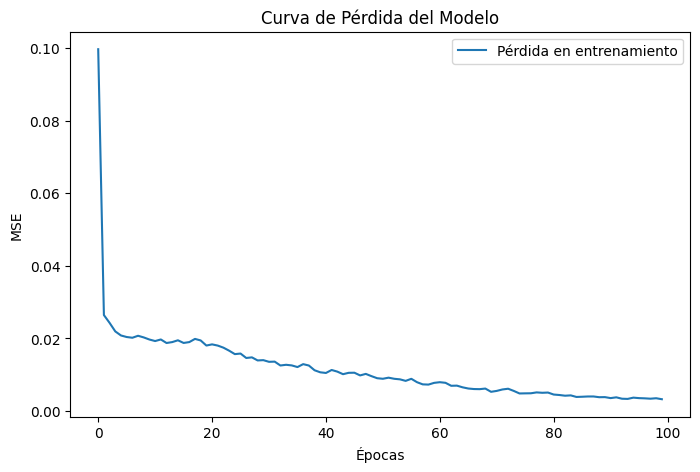

In [34]:
# Construir el modelo mejorado
model = keras.Sequential([
    # Capa convolucional para extracción de características
    layers.Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(window_size, 1)),
    layers.MaxPooling1D(pool_size=2),
    layers.BatchNormalization(),  # Normalización para estabilidad

    # Primera capa LSTM con Dropout
    layers.LSTM(150, return_sequences=True, activation='tanh'),
    layers.Dropout(0.3),

    # Segunda capa LSTM con Dropout
    layers.LSTM(75, return_sequences=True, activation='tanh'),
    layers.Dropout(0.3),

    # Última capa LSTM sin return_sequences
    layers.LSTM(50, activation='tanh'),

    # Capas densas finales
    layers.Dense(25, activation='relu'),
    layers.Dense(1)
])

# Compilar el modelo con un optimizador más ajustado
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='mse')

# Entrenar el modelo sin validación, ya que solo tenemos una serie temporal
history = model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1)

# Graficar la pérdida
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Pérdida en entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('MSE')
plt.legend()
plt.title('Curva de Pérdida del Modelo')
plt.show()



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 754ms/step - loss: 0.0036
Pérdida en el conjunto de prueba: 0.003608153434470296


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step
MAE: 0.11762363197583998
RMSE: 0.13943348660817048


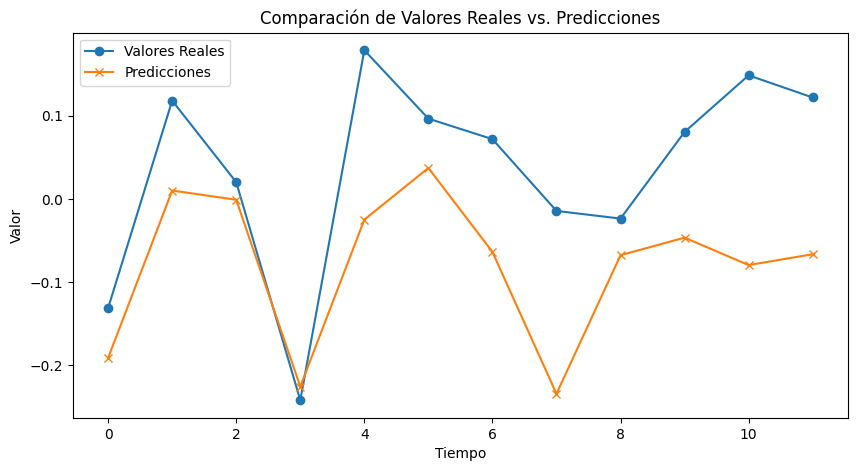

In [35]:
# Evaluar el modelo
loss = model.evaluate(X_test, y_test)
print(f"Pérdida en el conjunto de prueba: {loss}")

# Hacer predicciones
predictions_scaled = model.predict(X_test)

# Invertir la normalización para obtener las predicciones en la escala original
predictions = scaler.inverse_transform(predictions_scaled)
y_test_original = scaler.inverse_transform(y_test)

# Calcular métricas de error
mae = mean_absolute_error(y_test_original, predictions)
rmse = np.sqrt(mean_squared_error(y_test_original, predictions))
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")

# Graficar la serie temporal con valores reales y predicciones
plt.figure(figsize=(10, 5))
plt.plot(range(len(y_test_original)), y_test_original, label='Valores Reales', marker='o')
plt.plot(range(len(predictions)), predictions, label='Predicciones', marker='x')
plt.xlabel('Tiempo')
plt.ylabel('Valor')
plt.legend()
plt.title('Comparación de Valores Reales vs. Predicciones')
plt.show()


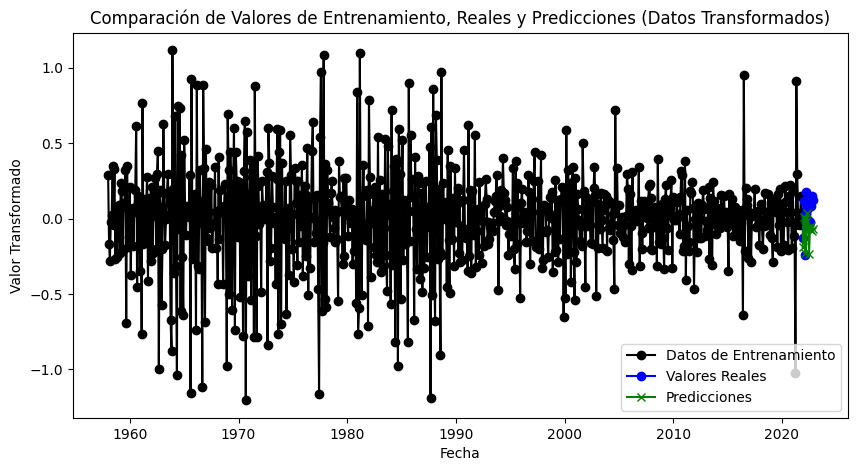

In [36]:
# Graficar la serie temporal con valores reales y predicciones
plt.figure(figsize=(10, 5))
plt.plot(df.iloc[:train_size, 0], transformed_df.iloc[:train_size], label='Datos de Entrenamiento', color='black', marker='o')
plt.plot(df.iloc[train_size:train_size+12, 0], y_test_original, label='Valores Reales', color='blue', marker='o')
plt.plot(df.iloc[train_size:train_size+12, 0], predictions, label='Predicciones', color='green', marker='x')
plt.xlabel('Fecha')
plt.ylabel('Valor Transformado')
plt.legend()
plt.title('Comparación de Valores de Entrenamiento, Reales y Predicciones (Datos Transformados)')
plt.show()


In [37]:
# Guardar las predicciones en un archivo CSV
fechas_test = df.iloc[train_size:train_size+12, 0].values  # Extraer las fechas correspondientes a los últimos 12 meses
resultados = pd.DataFrame({'Fecha': fechas_test, 'Valor Real Transformado': y_test_original.flatten(), 'Predicción Transformada': predictions.flatten()})
resultados.to_csv('predicciones_transformadas.csv', index=False)
print("Predicciones guardadas en 'predicciones_transformadas.csv'")

Predicciones guardadas en 'predicciones_transformadas.csv'


In [38]:
# Reentrenar el modelo con todos los datos
X_full, y_full = sequences, targets
model.fit(X_full, y_full, epochs=100, batch_size=64, verbose=1)

# Guardar el modelo
model.save("modelo_exportaciones.h5")
print("Modelo guardado como 'modelo_exportaciones.h5'")

# Generar las próximas 6 predicciones
def predict_future(model, last_sequence, steps):
    future_preds_scaled = []
    current_sequence = last_sequence.copy()
    for _ in range(steps):
        pred_scaled = model.predict(current_sequence.reshape(1, window_size, 1))
        future_preds_scaled.append(pred_scaled[0, 0])
        current_sequence = np.roll(current_sequence, -1)
        current_sequence[-1] = pred_scaled

    future_preds = scaler.inverse_transform(np.array(future_preds_scaled).reshape(-1, 1)).flatten()
    return future_preds



Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0029
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0034
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0033
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0036
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0033
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - loss: 0.0033
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - loss: 0.0032
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0030
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0032
Epoch 10/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0028
Epoch 11/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0030
Epoch 12/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0029
Epoch 13/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0027
Epoch 14/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0034
Epoch 15/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - 

Modelo guardado como 'modelo_exportaciones.h5'


In [39]:
last_sequence = sequences[-1]
future_predictions = predict_future(model, last_sequence, 6)

# Desnormalizar las predicciones
future_predictions = scaler.inverse_transform(future_predictions.reshape(-1, 1)).flatten()
# Crear un DataFrame con las predicciones futuras desnormalizadas
fechas_futuras = pd.date_range(start=df.iloc[-1, 0], periods=7, freq='M')[1:]
predicciones_futuras_df = pd.DataFrame({'Fecha': fechas_futuras, 'Predicción': future_predictions})

# Guardar las predicciones futuras en un archivo CSV
predicciones_futuras_df.to_csv('predicciones_futuras.csv', index=False)
print("Predicciones futuras guardadas en 'predicciones_futuras.csv'")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 784ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Predicciones futuras guardadas en 'predicciones_futuras.csv'


<ipython-input-39-244c9e1c3129>:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  fechas_futuras = pd.date_range(start=df.iloc[-1, 0], periods=7, freq='M')[1:]


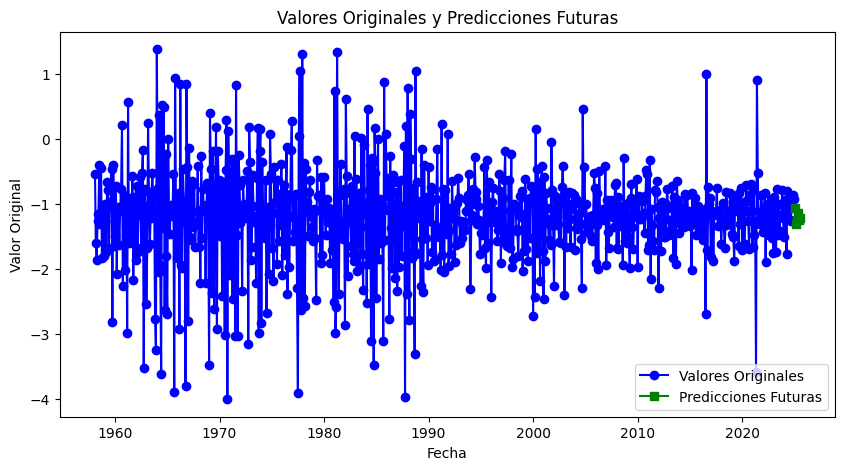

In [40]:
# Graficar la serie completa con las predicciones futuras desnormalizadas
plt.figure(figsize=(10, 5))
plt.plot(df.iloc[1:, 0], scaler.inverse_transform(diff_log_serie.reshape(-1, 1)).flatten(), label='Valores Originales', marker='o', color='blue')
plt.plot(fechas_futuras, future_predictions, label='Predicciones Futuras', marker='s', color='green')
plt.xlabel('Fecha')
plt.ylabel('Valor Original')
plt.legend()
plt.title('Valores Originales y Predicciones Futuras')
plt.show()

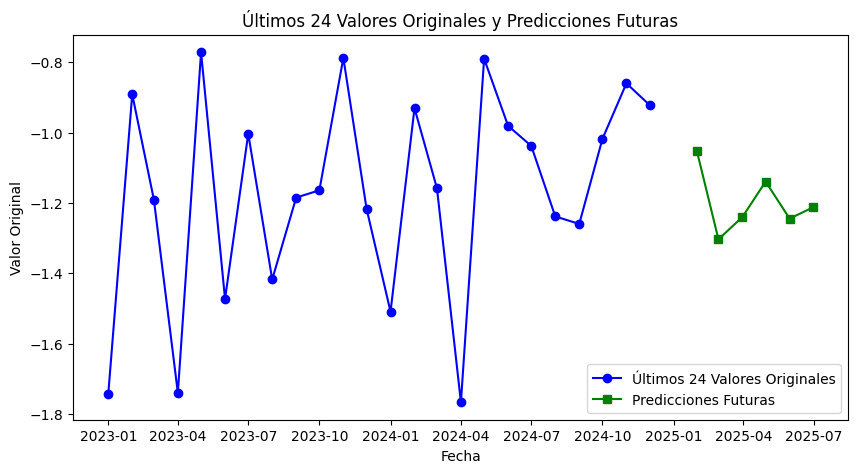

In [41]:
# Graficar los últimos 24 valores desnormalizados y las predicciones futuras
plt.figure(figsize=(10, 5))
plt.plot(df.iloc[-24:, 0], scaler.inverse_transform(transformed_df.iloc[-24:].values.reshape(-1, 1)).flatten(), label='Últimos 24 Valores Originales', marker='o', color='blue')
plt.plot(fechas_futuras, future_predictions, label='Predicciones Futuras', marker='s', color='green')
plt.xlabel('Fecha')
plt.ylabel('Valor Original')
plt.legend()
plt.title('Últimos 24 Valores Originales y Predicciones Futuras')
plt.show()

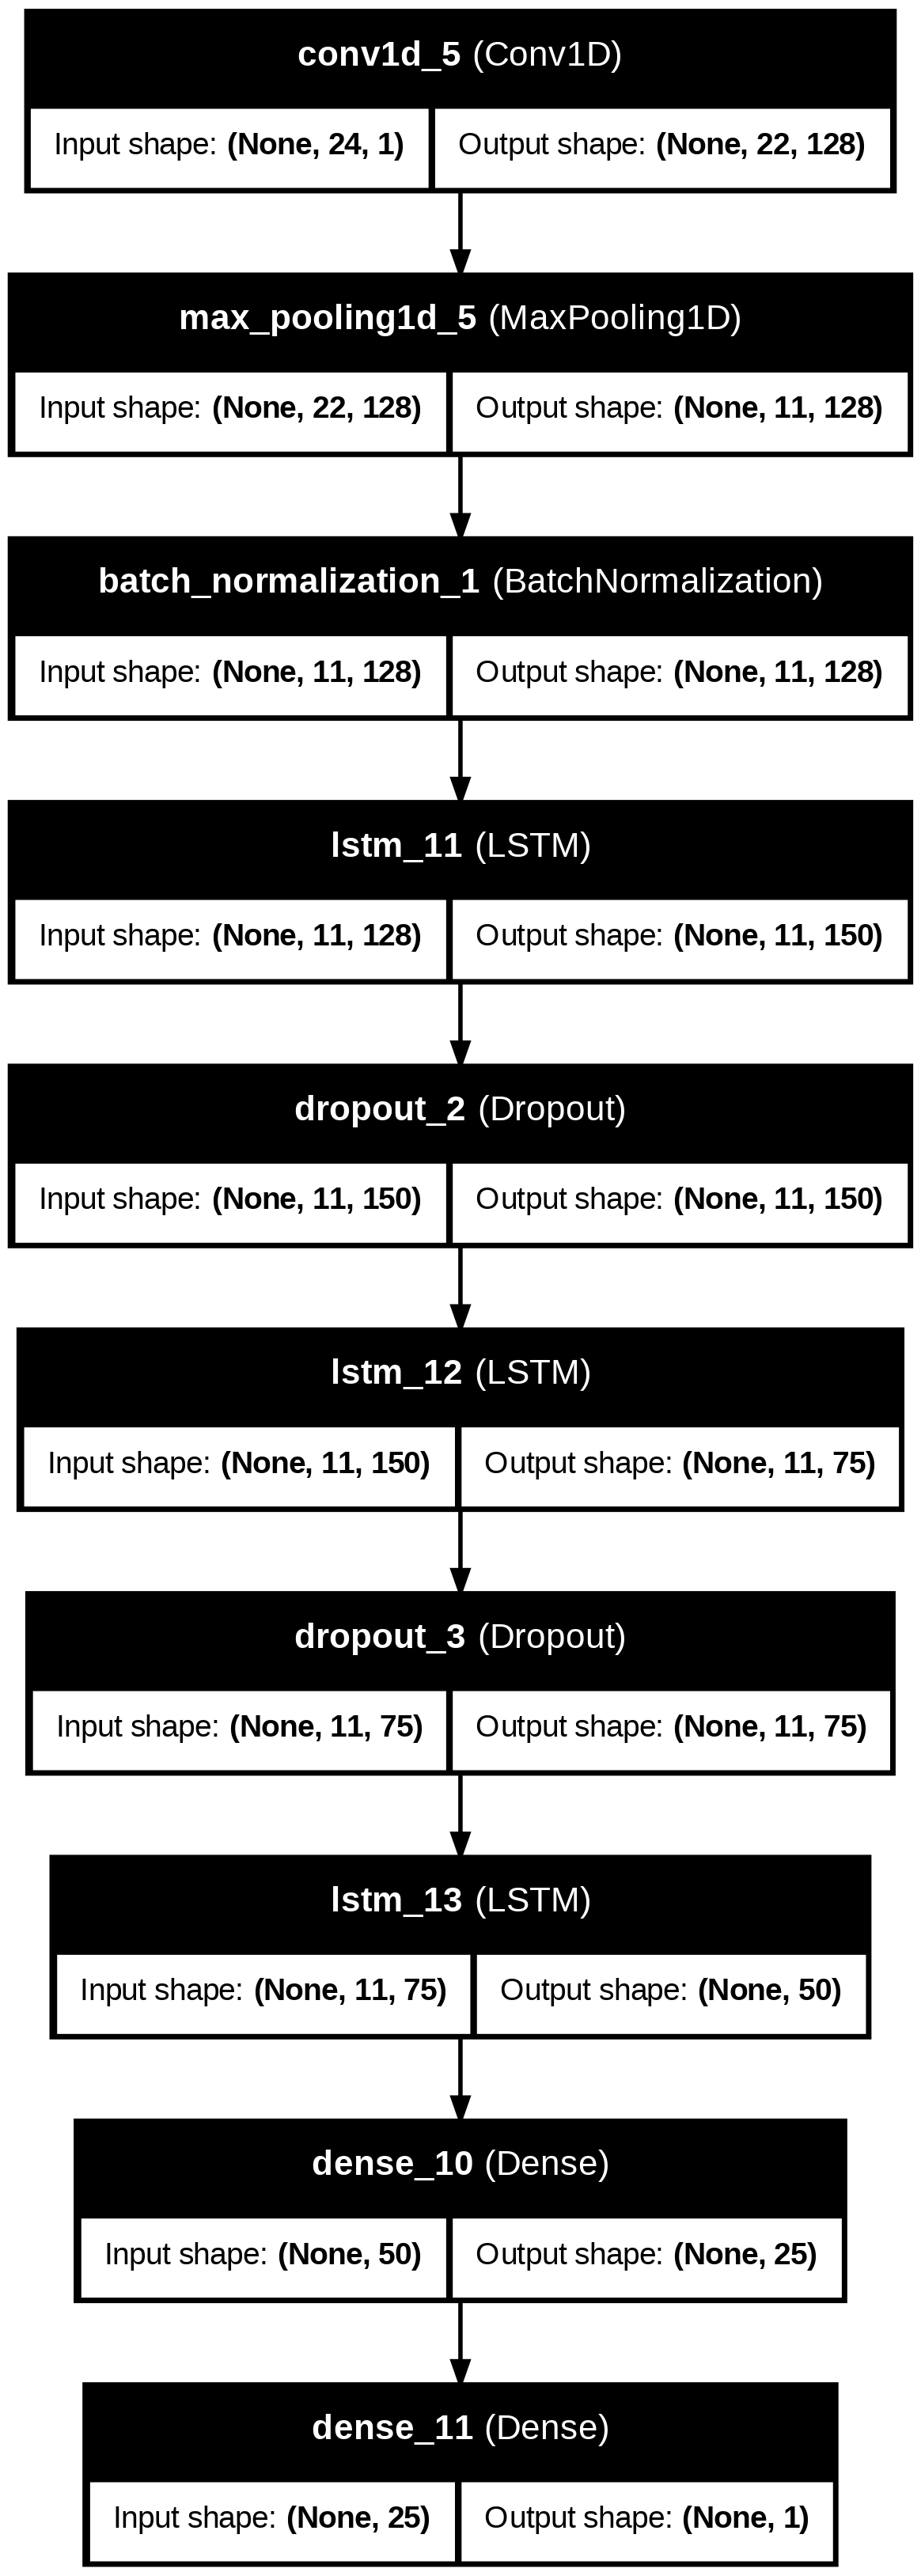

In [42]:
from tensorflow import keras
from tensorflow.keras.utils import plot_model
import graphviz

# Cargar el modelo sin compilar
model = keras.models.load_model("modelo_exportaciones.h5", compile=False)

# Opcional: recompilar el modelo si planeas usarlo para predicciones
model.compile(optimizer="adam", loss="mse")

# Guardar el gráfico de la arquitectura del modelo
plot_model(model, to_file="modelo_arquitectura.png", show_shapes=True, show_layer_names=True)

